## A more clean notebook

In [1]:
# Load all packages
import torch
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
     
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib
from torch import nn
import neptune.new as neptune

### Start the neptune run

In [140]:
# Get the APi key, from outside the git folder.
file = open("../API-key.txt", "r")
key = file.readlines()

run = neptune.init(
    project="Facemask-project/Facemask",
    api_token=key[0])

# Choose the device:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

https://app.neptune.ai/Facemask-project/Facemask/e/FAC-15
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## Create the dataloader

This Dataloader is using read_image, which is not the fastest way to load files. It might be better to use the cv2 library.

In [141]:

#Create the data loader. This data
class DataLoader(Dataset):
    def __init__(self, img_dir, img_dir2, transform = None, target_transform=None):
        self.img_dir = img_dir
        self.img_dir2 = img_dir2
        self.transform = transform
        self.fileNames = os.listdir(img_dir)
    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        label = self.fileNames[idx].rsplit("t-mask-", 1 )[1]
        img_path = os.path.join(self.img_dir, self.fileNames[idx])
        img_path2 = os.path.join(self.img_dir2, label)
        image = read_image(img_path)
        image2 = read_image(img_path2)
        image = image.clone().detach().float()
        image2 = image2.clone().detach().float()
        if self.transform:
            image = self.transform(image)
            image2 = self.transform(image2)
        return image, image2

## Set up the dataLoader

In [142]:
#Choose batch_size:
batch_size = 25

#create transformer with mean = 0 and std = 1.
transformer=transforms.Compose([ transforms.Normalize((0, 0, 0), (1, 1, 1)),])

#Create the dataset with the dataloader:
dataset = DataLoader("Data_small/50_with_mask", "Data_small/50_without_mask", transform = transformer) 

# split the dataset into test and train set.
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
test_train_split = [test_size, train_size]
testdata, traindata = torch.utils.data.random_split(dataset = dataset, lengths = test_train_split)

# Set up dataloader and the test
trainloader = torch.utils.data.DataLoader(traindata, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=0,
                                          pin_memory=True)
testloader = torch.utils.data.DataLoader(testdata, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=0,
                                          pin_memory=True)
dataiter = iter(trainloader)


## Set up the network

In [156]:
# with auto encoder:

import torch.nn.functional as F
class Model1(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
           
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(4608,5000)
        self.linear2 = nn.Linear(5000,4050)

        
        self.unflatten = nn.Unflatten(dim =1, unflattened_size = (18,15,15))
        #Encoder
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv11 = nn.Conv2d(8, 16, 3, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 50, 7, padding=3)
        self.conv4 = nn.Conv2d(50, 60, 5, padding=2)
        self.conv5 = nn.Conv2d(60, 40, 3, padding=1)
        self.conv6 = nn.Conv2d(40, 32, 3, padding=1)
       
        self.pool = nn.MaxPool2d(2, 2)
        
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(18, 12, 3, stride=1, dilation = 1, padding = 2)
        self.t_conv2 = nn.ConvTranspose2d(12, 8, 2, stride=2, dilation = 1, padding = 1, output_padding = 1)
        self.t_conv3 = nn.ConvTranspose2d(8, 3 , 2, stride = 2, dilation = 1, padding = 0)

    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = F.relu(self.conv6(x))
        return x
    
    def flatlayer(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        return x
    
    def decode(self, x):
        x = self.unflatten(x)
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        return x
        
    def forward(self, x):
        x = self.encode(x)
        x = self.flatlayer(x)
        x = self.decode(x)      
        return x


#Instantiate the model
model = ConvAutoencoder()

#Send the model to the device
model.to(device)
# check the model output is the correct size
model(dataiter.next()[0].to(device)).size()

torch.Size([25, 3, 50, 50])

In [158]:
print(inspect.getsource(Model1))

TypeError: <class '__main__.Model1'> is a built-in class

In [144]:
run["test"] = model

### Set up the neptune parameters

In [52]:
learning_rate = 0.001
#Loss function
criterion = torch.nn.MSELoss()

#Optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def update_params():
    run["parameters"] = {"lr": learning_rate,
                         "optim": str(optimizer).split(" ")[0],
                         "loss_function" : str(criterion),
                         "Batch_size": batch_size
                        }
update_params()

### Create the training function

In [53]:
#Epochs
def train(model, n_epochs = 10, criterion = criterion, optimizer = optimizer, trainloader = trainloader):
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0

        #Training
        for data in trainloader:
            mask_image, image = data
            mask_image , image = mask_image.to(device), image.to(device)
            image = image.clone().detach().float()
            mask_image = mask_image.clone().detach().float()
            optimizer.zero_grad()
            outputs = model(mask_image)
            loss = criterion(outputs, image)
            loss.backward()
            optimizer.step()
        if (epoch % 1 == 0):
            train_loss += loss.item()
            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
            run["train/loss"].log(train_loss)
        if (epoch % 50 ==0):
            checpoint_name = "checkpoint" + str(epoch)
            save_checkpoint(model, checpoint_name)
           

### Train the model

In [73]:
train(model, n_epochs = 2)

Epoch: 1 	Training Loss: 484.564575
Epoch: 2 	Training Loss: 437.018951
Epoch: 3 	Training Loss: 435.393616
Epoch: 4 	Training Loss: 454.292267
Epoch: 5 	Training Loss: 386.433289
Epoch: 6 	Training Loss: 403.166199
Epoch: 7 	Training Loss: 406.369446
Epoch: 8 	Training Loss: 349.759735
Epoch: 9 	Training Loss: 350.200897
Epoch: 10 	Training Loss: 395.357056


### function to print images:

In [74]:
def print_image(image, model, correct_image):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(np.transpose(image.numpy(), (1, 2, 0)).astype('uint8'))
    ax2.imshow(np.transpose(correct_image.numpy(), (1, 2, 0)).astype('uint8'))
    image = torch.unsqueeze(image,0)
    image = image.clone().detach().float()
    image = image.to(device)
    output = model(image)
    output = torch.squeeze(output,0)
    if device.type == 'cuda':
        output = torch.Tensor.cpu(output).clone().detach().numpy()
    else:
        output = output.clone().detach().numpy()
        

    ax3.imshow(np.transpose(output, (1, 2, 0)).astype('uint8'))
    plt.show()

In [56]:
dataiter = iter(testloader)

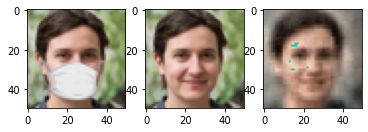

In [96]:
#Test a Model


images, images2 = dataiter.next()
#print_image(images[0], model = model2, correct_image = images2[0])
print_image(images[0], model = model, correct_image = images2[0])

In [23]:
#Save the model as a artifact
def save_checkpoint(model, checkpoint_name):
    checkpoint_name_ext = checkpoint_name + ".pt"
    checkpoints = os.listdir("Checkpoints")
    path = os.path.join("Checkpoints", checkpoint_name_ext)
    try_number = 0
    while (os.path.exists(path)):
        try_number += 1
        checkpoint_name_ext = checkpoint_name + "_" + str(try_number) + ".pt"
        path = os.path.join("Checkpoints", checkpoint_name_ext)
    torch.save(model, path)
    neptune_checkpoint_path = 'model_checkpoints/' + checkpoint_name + "_" + str(try_number)
    run[neptune_checkpoint_path].upload(path)

In [97]:
save_checkpoint(model,"size_50_smaller decoder")

In [130]:
model = torch.load("Checkpoints/size_50_spohcs_300.pt")

In [128]:
from torchvision import models
from torchsummary import summary
summary(model.cuda(),(3,50,50))

NotImplementedError: 

In [132]:
model_a = torch.load("Checkpoints/size_50_spohcs_300.pt").cpu()
model_a.eval()


# Display all model layer weights
for name, para in model_a.named_parameters():
    print('{}: {}'.format(name, para.shape))

linear1.weight: torch.Size([2500, 1728])
linear1.bias: torch.Size([2500])
linear2.weight: torch.Size([1600, 2500])
linear2.bias: torch.Size([1600])
linear3.weight: torch.Size([1200, 1600])
linear3.bias: torch.Size([1200])
conv1.weight: torch.Size([16, 3, 3, 3])
conv1.bias: torch.Size([16])
conv2.weight: torch.Size([32, 16, 3, 3])
conv2.bias: torch.Size([32])
conv3.weight: torch.Size([44, 32, 3, 3])
conv3.bias: torch.Size([44])
conv4.weight: torch.Size([32, 44, 3, 3])
conv4.bias: torch.Size([32])
conv5.weight: torch.Size([16, 32, 3, 3])
conv5.bias: torch.Size([16])
conv6.weight: torch.Size([12, 16, 3, 3])
conv6.bias: torch.Size([12])
t_conv1.weight: torch.Size([12, 16, 3, 3])
t_conv1.bias: torch.Size([16])
t_conv2.weight: torch.Size([16, 32, 3, 3])
t_conv2.bias: torch.Size([32])
t_conv3.weight: torch.Size([32, 16, 3, 3])
t_conv3.bias: torch.Size([16])
t_conv4.weight: torch.Size([16, 8, 2, 2])
t_conv4.bias: torch.Size([8])
t_conv5.weight: torch.Size([8, 3, 3, 3])
t_conv5.bias: torch.Size

Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterTimeout
Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterConnectionError
Communication with Neptune restored!
Communication with Neptune restored!


In [124]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

### Stop the run

In [133]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!


## check speed of code:

In [87]:
%load_ext line_profiler

In [88]:
%lprun -f train train(model, n_epochs = 2)

Epoch: 1 	Training Loss: 333.655579
Epoch: 2 	Training Loss: 434.678711
